# PENDIENTES
- Organizacion: poner funcion de descomposicion en funcion de utils.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [3]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\1703249404.py:1: SyntaxWarning: invalid escape sequence '\D'
  demanda_df = pd.read_csv(".\Datos\demanda.csv")


In [4]:
demanda_prod_df = demanda_df[demanda_df['id_producto']==1]
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

# Primero, asegurar que todas las fechas estan
# Los datos de demanda iniciales no tienen enero 2020
fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=fecha_inicial, end=demanda_prod_df['date'].max())})
complete_demanda_prod_df = fechas_df.merge(demanda_prod_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )


complete_demanda_prod_df['anio'] = complete_demanda_prod_df['date'].dt.year
complete_demanda_prod_df['mes'] = complete_demanda_prod_df['date'].dt.month
complete_demanda_prod_df['dia'] = complete_demanda_prod_df['date'].dt.day

C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\1390649101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


In [5]:
# Preprocesamiento de la serie de tiempo
complete_demanda_prod_df['demanda'].ffill(inplace=True)
complete_demanda_prod_df['demanda'].bfill(inplace=True)


# Eliminacion de 29 de febrero.
complete_demanda_prod_df = complete_demanda_prod_df.sort_values(by='date', ascending=True)
complete_demanda_prod_df.reset_index(drop=True, inplace=True)

# Crear una columna indicadora para el 29 de febrero
complete_demanda_prod_df['is_feb_29'] = complete_demanda_prod_df['date'].apply(lambda x: x.month == 2 and x.day == 29)
complete_demanda_prod_df = complete_demanda_prod_df[~complete_demanda_prod_df['is_feb_29']]

C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\3688260578.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_demanda_prod_df['demanda'].ffill(inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\3688260578.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [6]:
# Evaluacion de la varianza para saber si necesita alguna transformacion con la prueba de Levine
antes_comp_df = complete_demanda_prod_df[complete_demanda_prod_df['date'] < '2021-07-02']
antes_comp_df.reset_index(inplace=True, drop=True)
despues_comp_df = complete_demanda_prod_df[complete_demanda_prod_df['date'] >= '2021-07-02']
despues_comp_df.reset_index(inplace=True, drop=True)

## Nota
Hacer transformaciones separando datasets antes y despues de la competencia y volver a unir.

In [7]:
# Aplicando transformacion log a datos para que la varianza no cambie
antes_comp_df['log_demanda'] = np.log(antes_comp_df['demanda'] + 1)
despues_comp_df['log_demanda'] = np.log(despues_comp_df['demanda'] + 1)


# Funcion para aplicar transformaciones (normalizacion y quizas log o raiz cuadrada)
scaler_antes = StandardScaler()
scaler_despues = StandardScaler()

scaler_antes.fit(antes_comp_df['log_demanda'].values.reshape(-1, 1))
scaler_despues.fit(despues_comp_df['log_demanda'].values.reshape(-1, 1))

antes_comp_df['log_demanda_z_scaled'] = scaler_antes.transform(antes_comp_df['log_demanda'].values.reshape(-1, 1))
despues_comp_df['log_demanda_z_scaled'] = scaler_despues.transform(despues_comp_df['log_demanda'].values.reshape(-1, 1))
#antes_comp_df['log_demanda_z_scaled'] = scaler_antes.fit_transform(antes_comp_df['log_demanda'].values.reshape(-1, 1))
#despues_comp_df['log_demanda_z_scaled'] = scaler_antes.fit_transform(despues_comp_df['log_demanda'].values.reshape(-1, 1))

# Funcion para crear variables exogenas
antes_comp_df['dia_de_semana'] = antes_comp_df['date'].dt.weekday.astype(int)
antes_comp_df['es_fin_de_semana'] = antes_comp_df['date'].dt.weekday.isin([5,6]).astype(int)

despues_comp_df['dia_de_semana'] = despues_comp_df['date'].dt.weekday.astype(int)
despues_comp_df['es_fin_de_semana'] = despues_comp_df['date'].dt.weekday.isin([5,6]).astype(int)

C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\4012779717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  antes_comp_df['log_demanda'] = np.log(antes_comp_df['demanda'] + 1)
C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\4012779717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df['log_demanda'] = np.log(despues_comp_df['demanda'] + 1)
C:\Users\juanc\AppData\Local\Temp\ipykernel_16540\4012779717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [8]:
# Union de los datasets
preprocessed_df = pd.concat([antes_comp_df, despues_comp_df], axis=0)
preprocessed_df.drop(columns=['is_feb_29'], inplace=True)
preprocessed_df = preprocessed_df.sort_values(by='date', ascending=True)

In [9]:
# Calculo de la diferencia de variacion
preprocessed_df['demanda_diff_1_anio'] = preprocessed_df['demanda'].shift(365)
preprocessed_df.dropna(subset=['demanda_diff_1_anio'], inplace=True)
preprocessed_df.reset_index(inplace=True, drop=True)
preprocessed_df['var_rel_1_anio'] = (preprocessed_df['demanda_diff_1_anio'] - preprocessed_df['demanda']) / preprocessed_df['demanda']

preprocessed_df.drop(columns=['demanda_diff_1_anio'], inplace=True)

In [ ]:
# Transformacion logaritmica a variables continuas
preprocessed_df['log_var_rel_1_anio'] = np.log(preprocessed_df['var_rel_1_anio']+1)

# Escalamiento de variables numericas
exog_var_rel_scaler = StandardScaler()
preprocessed_df['log_var_rel_1_anio_z_scaled'] = exog_var_rel_scaler.fit_transform(preprocessed_df['log_var_rel_1_anio'].values.reshape(-1, 1))

# Encoding ciclico para variables ciclicas
preprocessed_df['mes_sin'] = np.sin(2 * np.pi *preprocessed_df['mes'] / 12)
preprocessed_df['mes_cos'] = np.cos(2 * np.pi *preprocessed_df['mes'] / 12)

preprocessed_df['dia_sin'] = np.sin(2 * np.pi *preprocessed_df['dia'] / 31)
preprocessed_df['dia_cos'] = np.cos(2 * np.pi *preprocessed_df['dia'] / 31)

preprocessed_df['dia_de_semana_sin'] = np.sin(2 * np.pi *preprocessed_df['dia_de_semana'] / 7)
preprocessed_df['dia_de_semana_cos'] = np.cos(2 * np.pi *preprocessed_df['dia_de_semana'] / 7)

# Datos booleanos transformados a enteros 1 o 0
# Flag de datos despues de aparicion de tienda de la competencia
fecha_cambio = pd.Timestamp("2021-07-02")
preprocessed_df["flg_date_despues_tienda_competencia"] = (preprocessed_df["date"] >= fecha_cambio).astype(int)


preprocessed_df['es_fin_de_semana'] = preprocessed_df['es_fin_de_semana'].astype(int)


In [11]:
# Seleccion de variables finales para modelo
preprocessed_df = preprocessed_df.loc[:, ['date', 'demanda','log_demanda_z_scaled', 'es_fin_de_semana', 'log_var_rel_1_anio_z_scaled'
                                           , 'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos', 'dia_de_semana_sin','dia_de_semana_cos']]

exog_cols = ['es_fin_de_semana', 'log_var_rel_1_anio_z_scaled'
             , 'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos', 'dia_de_semana_sin','dia_de_semana_cos']
X_exog = preprocessed_df.loc[:, exog_cols]

## Validacion cruzada con variable endogena preprocesada y exogenas

In [22]:
# Opcion 1, lo hacemos desde 0 con grid_search
import itertools
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

In [23]:
# Parámetros a probar
p_values = [2]  # AR
d_values = [1]  # Ya lo determinaste con ADF
q_values = [7, 15, 20, 25, 30, 35]  # MA

# Crear combinaciones de p, d, q
param_grid = list(itertools.product(p_values, d_values, q_values))

In [24]:
# Validacion cruzada con 3 splits
tscv = TimeSeriesSplit(n_splits=3)

In [25]:
# Lista que almacena sublistas con la combinacion de (p,d,q) y el promedio de los rmse con esos valores de parametros
results = []

for p, d ,q in param_grid:
    try:
        print(f"Inicio de ejecucion con ({p},{d},{q})")
        errors = []
        for train_idx, test_idx in tscv.split(preprocessed_df['log_demanda_z_scaled']):
            train, test = preprocessed_df['log_demanda_z_scaled'][train_idx], preprocessed_df['log_demanda_z_scaled'][test_idx]
            X_exog_train = X_exog.iloc[train_idx,:]
            X_exog_test = X_exog.iloc[test_idx,:]

            # Entrenamiento del modelo ARIMA con parametros actuales
            modelo = sm.tsa.arima.ARIMA(train, order=(p, d, q)
                                        , enforce_stationarity=True
                                        , enforce_invertibility=True
                                        , exog=X_exog_train
                                        )
            modelo_fit = modelo.fit()

            # Predicciones en el conjunto de prueba
            predictions = modelo_fit.forecast(steps=len(test), exog=X_exog_test)


            # Calculo de RMSE para un split
            split_rmse = np.sqrt(np.mean((predictions - test)**2))
            errors.append(split_rmse)

        # Promedio de los errores de os splits
        avg_rmse = np.mean(errors)
        results.append(((p, d, q), avg_rmse))
        print("Entrenamiento finalizado")
        print("----------------------------------")

    except Exception as e:
        print(f"Error con la combinacion ({p},{d},{q})")
        print(e)
        print("----------------------------------")
    #    continue # en caso de error se ignora esa combinacion
        

Inicio de ejecucion con (2,1,7)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,15)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,20)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting M

Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,25)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,30)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,35)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

Entrenamiento finalizado
----------------------------------


In [26]:
results

[((2, 1, 7), np.float64(1.6958355063722468)),
 ((2, 1, 15), np.float64(1.4426889220880124)),
 ((2, 1, 20), np.float64(1.3729738851054538)),
 ((2, 1, 25), np.float64(1.3673231458695703)),
 ((2, 1, 30), np.float64(1.440784615164132)),
 ((2, 1, 35), np.float64(1.5323873183530996))]

In [ ]:
# Seleccionar los mejores parámetros (menor RMSE)
best_params, best_rmse = min(results, key=lambda x: x[1])

print(f"Mejor configuración de ARIMA: {best_params} con RMSE = {best_rmse}")

Mejor configuración de ARIMA: (2, 1, 23) con RMSE = 1.3059749433939773


In [ ]:
# Validacion de entrenamiento final con datos separacion de datos para graficar predicciones y datos finales de los ultimos N dias
N_forecast = 60
y_train = preprocessed_df['log_demanda_z_scaled'][:-N_forecast]
y_test = preprocessed_df['log_demanda_z_scaled'][-N_forecast:]

X_exog_train = X_exog.iloc[:-N_forecast, :]
X_exog_test = X_exog.iloc[-N_forecast:, :]

In [ ]:
# Ejecucion del modelo ARIMA
# Entrenamiento del modelo ARIMA con parametros actuales
modelo = sm.tsa.arima.ARIMA(y_train, order=(2, 1, 23)
                            , enforce_stationarity=True
                            , enforce_invertibility=True
                            , exog=X_exog_train
                            )
modelo_fit = modelo.fit(method_kwargs={"maxiter": 300})

# Predicciones en el conjunto de prueba
predictions = modelo_fit.forecast(steps=len(y_test), exog=X_exog_test)

# Calculo de RMSE para un split
split_rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f"RMSE = {split_rmse}")

RMSE = 0.7895975162485287


In [ ]:
# Transformaciones inversas para obtener datos finales y volver a calcular los predecidos.
dic_test = {'date': preprocessed_df['date'][-N_forecast:]
            ,'y_test_log_demanda_scaled': y_test
            ,'predicciones': predictions
            ,'demanda': preprocessed_df['demanda'][-N_forecast:]
            }

test_df = pd.DataFrame(dic_test)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
# Transformacion original de datos
test_df['original_predictions'] = test_df.apply(
    lambda row: np.exp(scaler_antes.inverse_transform([[row['predicciones']]])[0][0]) - 1
    if row['date'] < pd.Timestamp('2022-07-02') 
    else np.exp(scaler_despues.inverse_transform([[row['predicciones']]])[0][0]) - 1,
    axis=1
)

In [ ]:
# Calculo de RMSE final
rmse_final = np.sqrt(np.mean((test_df['original_predictions'] - test_df['demanda'])**2))
print(f"RMSE = {rmse_final}")

RMSE = 9.9422657013479


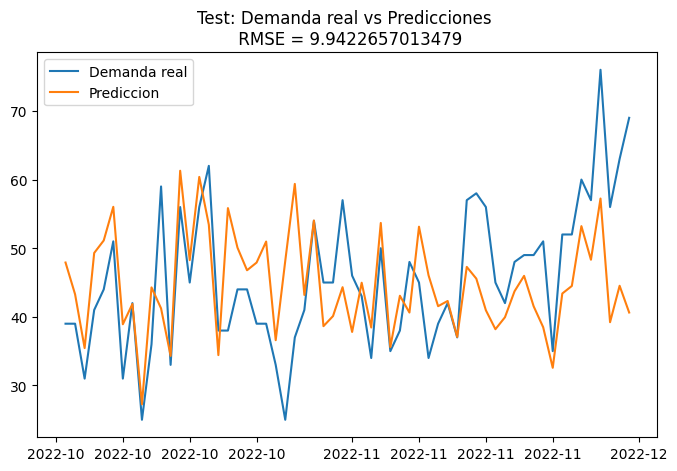

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(test_df['date'], test_df['demanda'])
plt.plot(test_df['date'], test_df['original_predictions'])

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.title(f"Test: Demanda real vs Predicciones \n RMSE = {rmse_final}")
plt.legend(['Demanda real', 'Prediccion'])
plt.show()

**PENDIENTES**
- Corregir variables exogenas
- Cross validation con 10 a 30 para parametro q.
- Evaluar seasonality
- Revisar como estimar tendencia, estacionalidad y ruido por separado y si es mejor que sobre los datos directamente

**VALIDACION DE ESTACIONALIDAD EN `log_demanda_z_scaled`**

In [16]:
from statsmodels.tsa.seasonal import STL

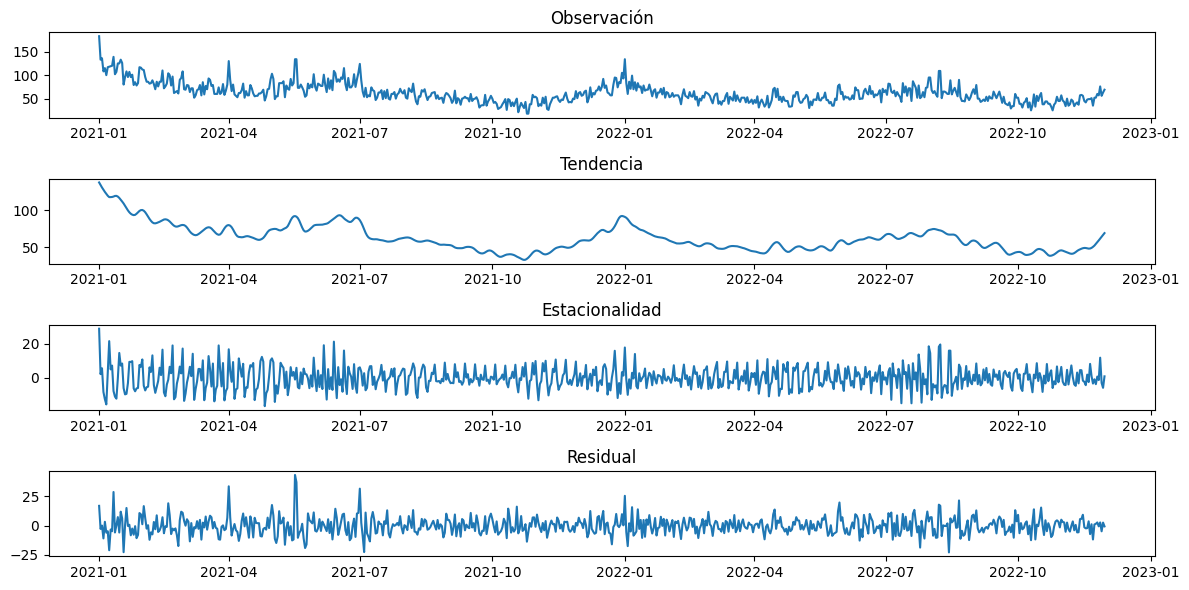

In [21]:
y = preprocessed_df['demanda']

stl = STL(preprocessed_df['demanda'], period=7)
decomposicion = stl.fit()

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(preprocessed_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(preprocessed_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(preprocessed_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(preprocessed_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()

In [18]:
# Pruebas de ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

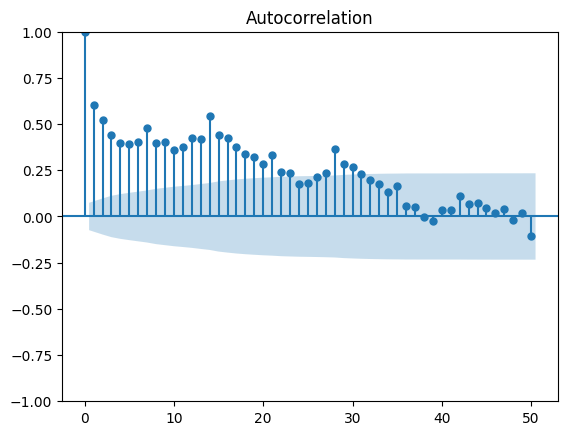

In [19]:
# Funcion de autocorrelacion (ACF): verifica dependencia de ventas pasadas en ventas futuras
plot_acf(preprocessed_df['log_demanda_z_scaled'], lags=50)
plt.show()

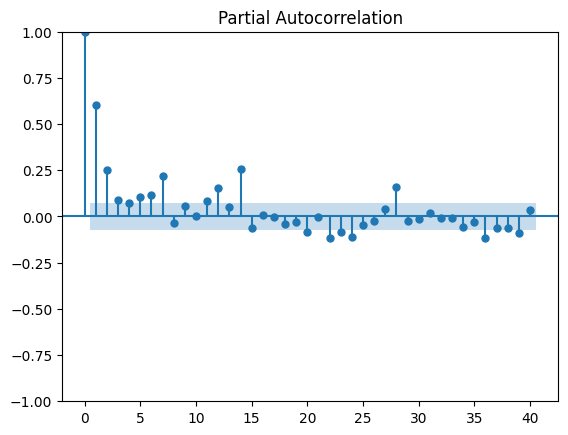

In [ ]:
# Partial Autocorrelation Function (PACF): identifica que lags son relevantes
plot_pacf(preprocessed_df['log_demanda_z_scaled'], lags=40)
plt.show()

In [20]:
preprocessed_df.columns

Index(['date', 'demanda', 'log_demanda_z_scaled', 'es_fin_de_semana',
       'log_var_rel_1_anio_z_scaled', 'mes_sin', 'mes_cos', 'dia_sin',
       'dia_cos', 'dia_de_semana_sin', 'dia_de_semana_cos'],
      dtype='object')